In [28]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle_dataset'

In [5]:
%cd /content/drive/MyDrive/kaggle_dataset

/content/drive/MyDrive/kaggle_dataset


In [6]:
!ls

cat-and-dog  kaggle.json


In [7]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:02<00:00, 106MB/s]
100% 218M/218M [00:02<00:00, 95.6MB/s]


In [8]:
!mkdir cat-and-dog
!mv cat-and-dog.zip cat-and-dog

mkdir: cannot create directory ‘cat-and-dog’: File exists


In [9]:
%cd cat-and-dog/

/content/drive/My Drive/kaggle_dataset/cat-and-dog


In [10]:
!unzip cat-and-dog.zip

Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
DATA_DIR = '/content/drive/MyDrive/kaggle_dataset/cat-and-dog'

In [12]:
TRAIN_DATADIR = os.path.join(DATA_DIR, 'training_set')
TEST_DATADIR = os.path.join(DATA_DIR, 'test_set')

In [13]:
train_dir = os.path.join(TRAIN_DATADIR, 'training_set')
test_dir = os.path.join(TEST_DATADIR, 'test_set')

In [14]:
CATEGORIES = []
for c in os.listdir(train_dir): 
  CATEGORIES.append(c)
print(CATEGORIES)

['cats', 'dogs']


In [15]:
train_data = []
test_data = []
IMG_SIZE = 200

In [16]:
for c in CATEGORIES:  
  path = os.path.join(train_dir, c) 
  class_num = CATEGORIES.index(c) 
  for img in tqdm(os.listdir(path)):
    try:
        img_arr = cv2.imread(os.path.join(path, img)) 
        img_resized = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) 
        train_data.append([img_resized, class_num])
    except Exception as e:
        pass

100%|██████████| 4006/4006 [00:28<00:00, 139.48it/s]


In [17]:
print(len(train_data))

8005


In [18]:
for c in CATEGORIES:  
  path = os.path.join(test_dir, c) 
  class_num = CATEGORIES.index(c) 
  for img in tqdm(os.listdir(path)):
    try:
        img_arr = cv2.imread(os.path.join(path, img)) 
        img_resized = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        test_data.append([img_resized, class_num])
    except Exception as e: 
        pass

100%|██████████| 1013/1013 [00:07<00:00, 138.07it/s]


In [19]:
print(len(test_data))

2023


In [20]:
X_train = []
Y_train = []
for img,label in train_data: 
  X_train.append(img)
  Y_train.append(label)


X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE,  3)
Y_train = np.array(Y_train)

print(X_train.shape, Y_train.shape)

(8005, 200, 200, 3) (8005,)


In [21]:
X_test = []
Y_test = []
for img,label in test_data: 
  X_test.append(img)
  Y_test.append(label)


X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE,  3)
Y_test = np.array(Y_test)

print(X_test.shape, Y_test.shape)

(2023, 200, 200, 3) (2023,)


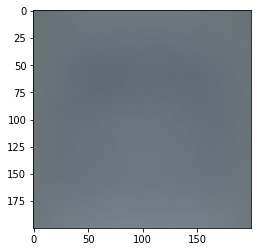

In [22]:
mean_img = np.mean(X_train, axis=0) 
plt.imshow(mean_img.astype('uint8'))

In [24]:

mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[13.413389 13.413389 13.413389]


In [25]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [26]:
for i in range(len(X_train)): 
    for c in range(3):       
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

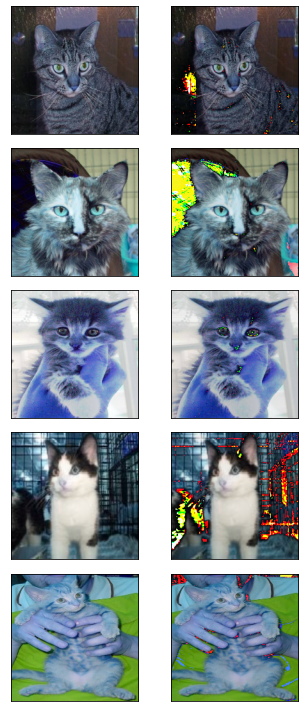

In [27]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [29]:
model = keras.Sequential([
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 100, 100, 128)     0

In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)
#Monitoring the validation loss
h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=20, 
              validation_split=0.2,
              batch_size=512,
              callbacks=[cb]
             )